In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 17.2 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 63.8 MB/s 
     |████████████████████████████████| 596 kB 78.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import pandas as pd, glob, re, string,seaborn as sns, random, numpy as np, os, transformers, torch, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support,roc_auc_score, classification_report, auc, roc_curve
from tqdm import tqdm
# specify GPU
device = torch.device("cuda")
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification ,BertTokenizer, AutoModel, AutoTokenizer,Trainer, TrainingArguments,AutoModelForPreTraining,AutoModelForSequenceClassification

In [4]:
def create_dataframe(path):
    train_files = glob.glob(path + "/*.csv")
    df = pd.concat([pd.read_csv(filename, index_col=None, header=0) for filename in train_files], axis=0, ignore_index=True)
    df = df.drop(['Unnamed: 0'],axis=1)
    return df
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf
        tf.random.set_seed(seed)
class LegalDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item
    def __len__(self):
        return len(self.labels)
def get_prediction(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to("cuda")
    outputs = model1(**inputs)
    probs = outputs[0].softmax(1)
    return target_names[probs.argmax()], probs.argmax().cpu().numpy()
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc,}
path = r'/content/drive/My Drive/LegalArguementMining/'
df_train = create_dataframe(path + "Train_data")
df_train,df_untouched = train_test_split(df_train, stratify=df_train['Target'], test_size=0.2)
df_test = create_dataframe(path + "test_data")
df_unlabelled = create_dataframe(path + "Unlabeled_data")
df_unlabelled_new = pd.read_csv(path + "Unlabelled_new/df_unlabelled_new.csv")

l = LabelEncoder().fit(df_train['Target'])
df_train['Target'] = l.transform(df_train['Target'])
df_untouched['Target'] = l.transform(df_untouched['Target'])
df_test['Target'] = l.transform(df_test['Target'])

print(df_train.shape)
print(df_untouched.shape)
print(df_unlabelled_new.shape)

#Corru[ting Train Data]
df_train1,df_sample = train_test_split(df_train, stratify=df_train['Target'], test_size=0.238004)
df_sample['Target'] = [i+1 if i!=6 else 0 for i in df_sample['Target']]
df_train = pd.concat([df_train1,df_sample,df_untouched,df_unlabelled_new[:10000]],axis=0)

print(df_train.shape)

train_texts , train_labels = df_train['Sentence'], df_train['Target']
valid_texts, valid_labels = df_test['Sentence'], df_test['Target']
test_texts, test_labels = df_untouched['Sentence'], df_untouched['Target']
target_names = df_train['Target'].value_counts().keys().tolist()

set_seed(1)
max_length = 512
model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names)).to("cuda")
train_encodings = tokenizer(train_texts.to_list(), truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts.to_list(), truncation=True, padding=True, max_length=max_length)

# convert our tokenized data into a torch Dataset
train_dataset = LegalDataset(train_encodings, train_labels.to_list())
valid_dataset = LegalDataset(valid_encodings, valid_labels.to_list())

(30168, 2)
(7543, 2)
(502560, 2)
(47711, 2)


Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=10000,               # log & save weights each logging_steps
    save_steps=10000,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)
trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

In [ ]:
# train the model
trainer.train()

In [ ]:
trainer._load_from_checkpoint("/content/drive/My Drive/LegalArguementMining/Models/bert4algo")

In [ ]:
# evaluate the current model after training
trainer.evaluate()

In [ ]:
model1 = BertForSequenceClassification.from_pretrained("/content/drive/My Drive/LegalArguementMining/models/bert4algo", num_labels=len(target_names)).to("cuda")
pred = [get_prediction(i)[1] for i in df_test.Sentence.values.tolist()]
print('Accuracy of Test Dataset :',accuracy_score(pred, df_test.Target.values.tolist()))

Accuracy of Test Dataset : 0.7677543186180422


[[ 49   8  15   0   1   2   2]
 [  2  23   1   0   0   0   0]
 [ 16   1 234   6   3   3   4]
 [  3   0  10  49   0   1   2]
 [  3   1   4   1  22   0   3]
 [  4   2   8   0   0   3   1]
 [  7   0   1   4   2   0  20]]
Accuracy =  0.76775432 
Precision =  0.76373732 
Recall =  0.76775432 
F-Score =  0.76309254 
AUC ROC =  0.80168312
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        77
           1       0.66      0.88      0.75        26
           2       0.86      0.88      0.87       267
           3       0.82      0.75      0.78        65
           4       0.79      0.65      0.71        34
           5       0.33      0.17      0.22        18
           6       0.62      0.59      0.61        34

    accuracy                           0.77       521
   macro avg       0.67      0.65      0.65       521
weighted avg       0.76      0.77      0.76       521



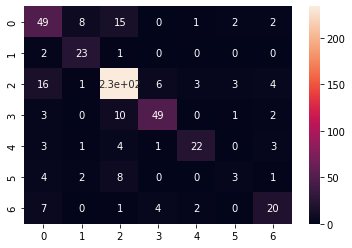

In [5]:
def confusion_matrixs(y, yp):
  k = sorted(list(set(y)))
  df = pd.DataFrame(index=k, columns=k)
  df.fillna(0, inplace=True)
  for i, j in zip(y, yp):
    df.loc[i, j] += 1
  sns.heatmap(df, annot=True)
  plt.plot()
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)
print(confusion_matrix(df_test.Target.values.tolist(), pred))
precision, recall, fscore, support = precision_recall_fscore_support(df_test.Target.values.tolist(), pred, average='weighted')
print('Accuracy = ',round(accuracy_score(pred, df_test.Target.values.tolist()),8),'\nPrecision = ',round(precision,8),
      '\nRecall = ', round(recall,8), '\nF-Score = ',round(fscore,8), 
      '\nAUC ROC = ', round(multiclass_roc_auc_score(df_test.Target.values.tolist(),np.array(pred), average="macro"),8))
confusion_matrixs(df_test.Target.values.tolist(),np.array(pred))
print(classification_report(df_test.Target.values.tolist(),np.array(pred)))